# torch.nn 实现空洞卷积

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import torchvision
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils import data

In [2]:
class DilatedConvModule(nn.Module):
    def __init__(self):
        super(DilatedConvModule,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,kernel_size=3,stride=1,padding=0,dilation=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0,dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0,dilation=5),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Linear(128,num_classes)
    def forward(self,X):
        out = self.conv(X)
        out = F.avg_pool2d(out,16)
        out = out.squeeze()
        out = self.fc(out)
        return out

In [3]:
def train_epoch(net,data_loader,device):
    net.train()
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    for batch_idx,(data,target) in enumerate(data_loader):
        data = data.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        prediction = torch.argmax(output,1)
        correct += (prediction == target).sum().item()
        sample_num += len(prediction)
    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss,acc

In [4]:
def test_epoch(net,data_loader,device):
    net.eval()
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

In [5]:
path_train = r'./车辆分类数据集/train/'  # 路径
path_test = r'./车辆分类数据集/test/'  # 路径

train = torchvision.datasets.ImageFolder(path_train, transform=transforms.Compose(
    [transforms.Resize((32, 32)), transforms.CenterCrop(32), transforms.ToTensor()]))
test =torchvision.datasets.ImageFolder(path_test, transform=transforms.Compose(
    [transforms.Resize((32, 32)), transforms.CenterCrop(32), transforms.ToTensor()]))

In [6]:
classes = ('bus','car','truck')
num_classes = 3
epochs = 100
lr = 0.001
batch_size = 64
device=torch.device("cpu")
train_loader = torch.utils.data.DataLoader(train,batch_size=batch_size,shuffle=True,num_workers=0)
test_loader = torch.utils.data.DataLoader(test,batch_size=batch_size,shuffle=True,num_workers=0)

In [7]:
net = DilatedConvModule().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=lr)
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
begin = time.time()
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(net, data_loader=train_loader,device=device)
    test_loss, test_acc = test_epoch(net, data_loader=test_loader, device=device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    if (epoch + 1) % 20 == 0:
        print(f"epoch:{epoch+1}\t train_loss:{train_loss:.5f}\t"
              f"train_acc:{train_acc:.5f}\t"
              f"test_loss:{test_loss:.5f}\t test_acc:{test_acc:.5f}")

epoch:20	 train_loss:0.07390	train_acc:0.97696	test_loss:0.21463	 test_acc:0.93015
epoch:40	 train_loss:0.02860	train_acc:0.99447	test_loss:0.19792	 test_acc:0.94485
epoch:60	 train_loss:0.02963	train_acc:0.99171	test_loss:0.27599	 test_acc:0.90441
epoch:80	 train_loss:0.01837	train_acc:0.99447	test_loss:0.27057	 test_acc:0.91544
epoch:100	 train_loss:0.00869	train_acc:0.99816	test_loss:0.23953	 test_acc:0.92647


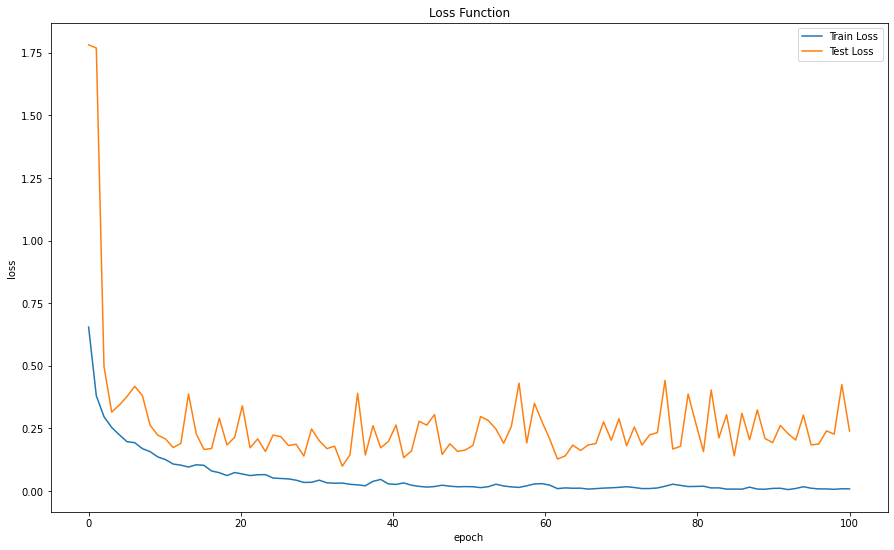

In [8]:
def Draw_Loss_Curve():
    plt.figure(figsize=(15, 9))
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss Function")
    x_loss = np.linspace(0, len(train_loss_list), len(train_loss_list))
    plt.plot(x_loss, train_loss_list, label=u'Train Loss', linewidth=1.5)
    plt.plot(x_loss, test_loss_list, label=u'Test Loss', linewidth=1.5)
    plt.legend()
    plt.show()
Draw_Loss_Curve()

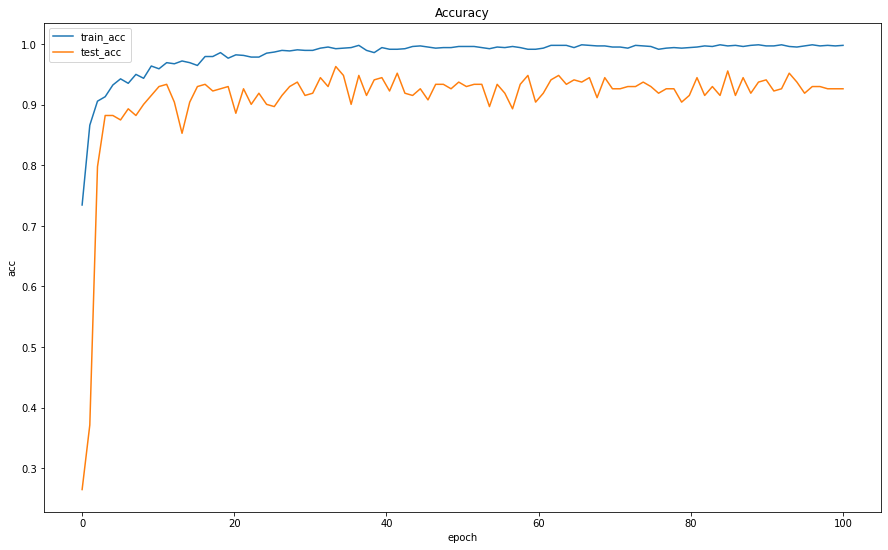

In [9]:
def Draw_Acc_Curve():
    plt.figure(figsize=(15, 9))
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.title("Accuracy")
    x_acc = np.linspace(0, len(train_acc_list), len(train_acc_list))
    plt.plot(x_acc, train_acc_list, label="train_acc", linewidth=1.5)
    plt.plot(x_acc, test_acc_list, label="test_acc", linewidth=1.5)
    plt.legend()
    plt.show()
Draw_Acc_Curve()

In [10]:
end = time.time()
print(end-begin)

448.63765811920166


## 调整卷积核大小

In [11]:
class DilatedConvModule(nn.Module):
    def __init__(self):
        super(DilatedConvModule,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,kernel_size=4,stride=1,padding=0,dilation=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=1, padding=0,dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=1, padding=0,dilation=5),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Linear(128,num_classes)
    def forward(self,X):
        out = self.conv(X)
        out = F.avg_pool2d(out,8)
        out = out.squeeze()
        out = self.fc(out)
        return out

In [12]:
def train_epoch(net,data_loader,device):
    net.train()
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    for batch_idx,(data,target) in enumerate(data_loader):
        data = data.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        prediction = torch.argmax(output,1)
        correct += (prediction == target).sum().item()
        sample_num += len(prediction)
    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss,acc

In [13]:
def test_epoch(net,data_loader,device):
    net.eval()
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

In [14]:
classes = ('bus','car','truck')
num_classes = 3
epochs = 100
lr = 0.001
batch_size = 64
device=torch.device("cpu")
train_loader = torch.utils.data.DataLoader(train,batch_size=batch_size,shuffle=True,num_workers=0)
test_loader = torch.utils.data.DataLoader(test,batch_size=batch_size,shuffle=True,num_workers=0)

In [15]:
net = DilatedConvModule().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=lr)
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
begin = time.time()
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(net, data_loader=train_loader,device=device)
    test_loss, test_acc = test_epoch(net, data_loader=test_loader, device=device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    if (epoch + 1) % 20 == 0:
        print(f"epoch:{epoch+1}\t train_loss:{train_loss:.5f}\t"
              f"train_acc:{train_acc:.5f}\t"
              f"test_loss:{test_loss:.5f}\t test_acc:{test_acc:.5f}")

epoch:20	 train_loss:0.03217	train_acc:0.99171	test_loss:0.08935	 test_acc:0.96691
epoch:40	 train_loss:0.00833	train_acc:0.99724	test_loss:0.14070	 test_acc:0.96691
epoch:60	 train_loss:0.00509	train_acc:0.99724	test_loss:0.12539	 test_acc:0.96691
epoch:80	 train_loss:0.00397	train_acc:0.99724	test_loss:0.18308	 test_acc:0.97426
epoch:100	 train_loss:0.00370	train_acc:0.99724	test_loss:0.14640	 test_acc:0.96324


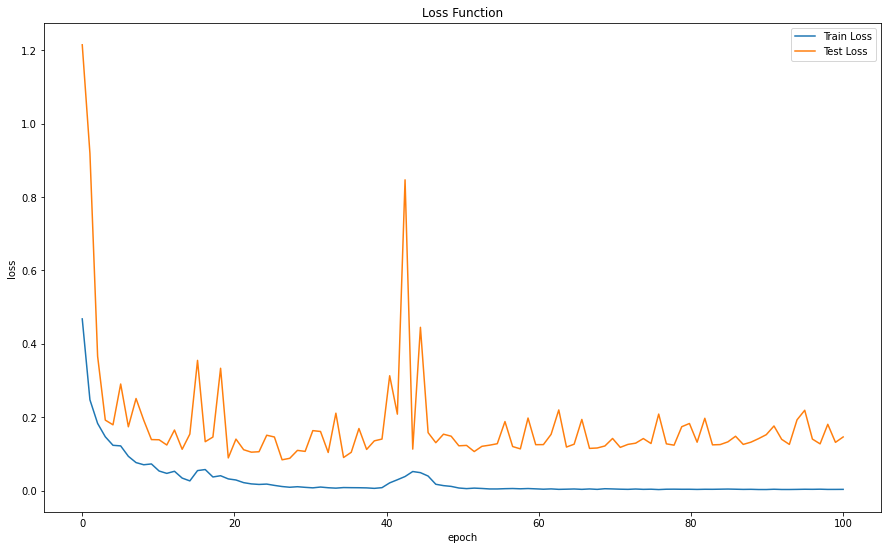

In [16]:
def Draw_Loss_Curve():
    plt.figure(figsize=(15, 9))
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss Function")
    x_loss = np.linspace(0, len(train_loss_list), len(train_loss_list))
    plt.plot(x_loss, train_loss_list, label=u'Train Loss', linewidth=1.5)
    plt.plot(x_loss, test_loss_list, label=u'Test Loss', linewidth=1.5)
    plt.legend()
    plt.show()
Draw_Loss_Curve()

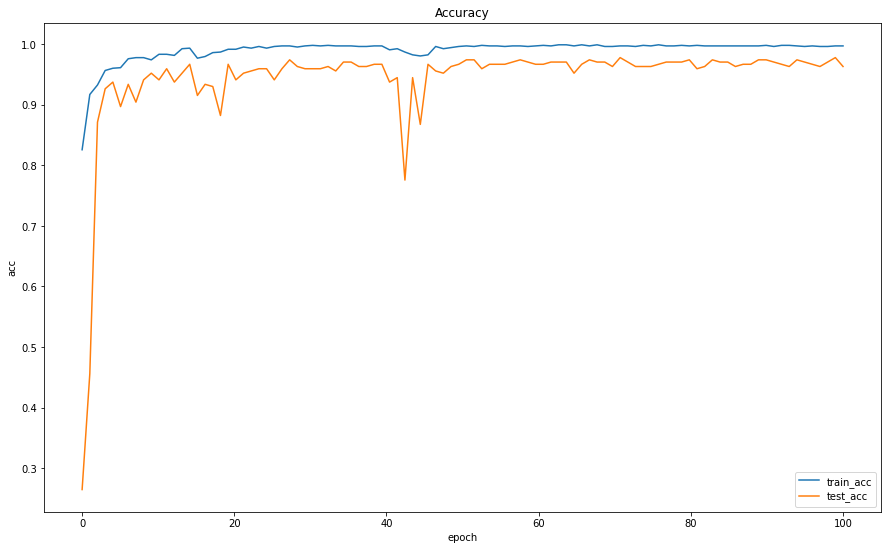

In [17]:
def Draw_Acc_Curve():
    plt.figure(figsize=(15, 9))
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.title("Accuracy")
    x_acc = np.linspace(0, len(train_acc_list), len(train_acc_list))
    plt.plot(x_acc, train_acc_list, label="train_acc", linewidth=1.5)
    plt.plot(x_acc, test_acc_list, label="test_acc", linewidth=1.5)
    plt.legend()
    plt.show()
Draw_Acc_Curve()

In [18]:
end = time.time()
print(end-begin)

374.1116979122162


## 调整膨胀率

In [19]:
class DilatedConvModule(nn.Module):
    def __init__(self):
        super(DilatedConvModule,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,kernel_size=3,stride=1,padding=0,dilation=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0,dilation=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0,dilation=5),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Linear(128,num_classes)
    def forward(self,X):
        out = self.conv(X)
        out = F.avg_pool2d(out,8)
        out = out.squeeze()
        out = self.fc(out)
        return out

In [20]:
def train_epoch(net,data_loader,device):
    net.train()
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    for batch_idx,(data,target) in enumerate(data_loader):
        data = data.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        prediction = torch.argmax(output,1)
        correct += (prediction == target).sum().item()
        sample_num += len(prediction)
    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss,acc

In [21]:
def test_epoch(net,data_loader,device):
    net.eval()
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

In [22]:
classes = ('bus','car','truck')
num_classes = 3
epochs = 100
lr = 0.001
batch_size = 64
device=torch.device("cpu")
train_loader = torch.utils.data.DataLoader(train,batch_size=batch_size,shuffle=True,num_workers=0)
test_loader = torch.utils.data.DataLoader(test,batch_size=batch_size,shuffle=True,num_workers=0)

In [23]:
net = DilatedConvModule().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=lr)
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
begin = time.time()
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(net, data_loader=train_loader,device=device)
    test_loss, test_acc = test_epoch(net, data_loader=test_loader, device=device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    if (epoch + 1) % 20 == 0:
        print(f"epoch:{epoch+1}\t train_loss:{train_loss:.5f}\t"
              f"train_acc:{train_acc:.5f}\t"
              f"test_loss:{test_loss:.5f}\t test_acc:{test_acc:.5f}")

epoch:20	 train_loss:0.03119	train_acc:0.99263	test_loss:0.17427	 test_acc:0.94118
epoch:40	 train_loss:0.00929	train_acc:0.99724	test_loss:0.19344	 test_acc:0.93750
epoch:60	 train_loss:0.01181	train_acc:0.99539	test_loss:0.15848	 test_acc:0.94853
epoch:80	 train_loss:0.01433	train_acc:0.99724	test_loss:0.27358	 test_acc:0.95956
epoch:100	 train_loss:0.00475	train_acc:0.99631	test_loss:0.31150	 test_acc:0.95588


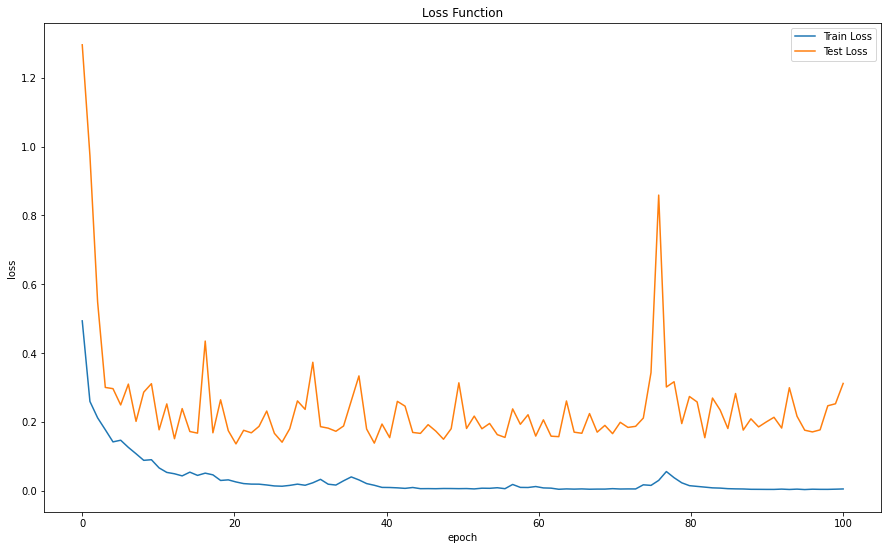

In [24]:
def Draw_Loss_Curve():
    plt.figure(figsize=(15, 9))
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss Function")
    x_loss = np.linspace(0, len(train_loss_list), len(train_loss_list))
    plt.plot(x_loss, train_loss_list, label=u'Train Loss', linewidth=1.5)
    plt.plot(x_loss, test_loss_list, label=u'Test Loss', linewidth=1.5)
    plt.legend()
    plt.show()
Draw_Loss_Curve()

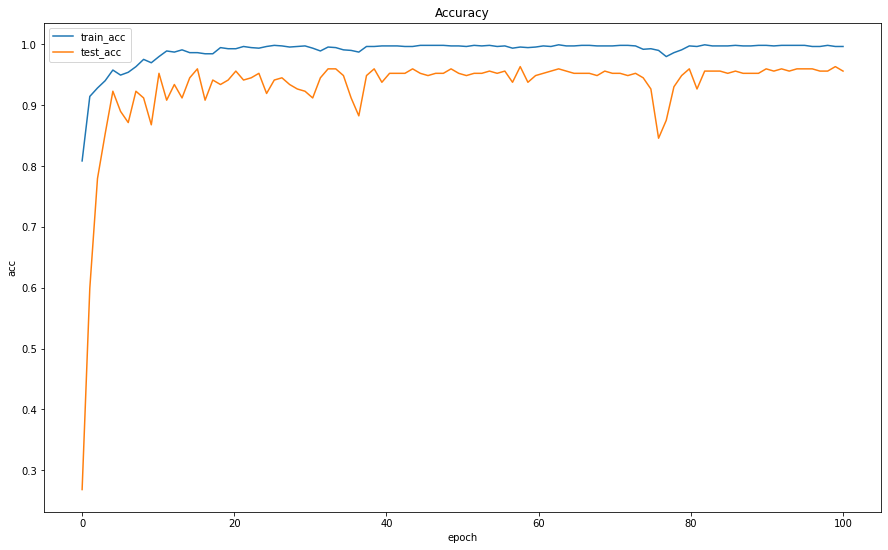

In [25]:
def Draw_Acc_Curve():
    plt.figure(figsize=(15, 9))
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.title("Accuracy")
    x_acc = np.linspace(0, len(train_acc_list), len(train_acc_list))
    plt.plot(x_acc, train_acc_list, label="train_acc", linewidth=1.5)
    plt.plot(x_acc, test_acc_list, label="test_acc", linewidth=1.5)
    plt.legend()
    plt.show()
Draw_Acc_Curve()

In [26]:
end = time.time()
print(end-begin)

384.98702907562256


## 调整学习率为 1e-4

In [27]:
class DilatedConvModule(nn.Module):
    def __init__(self):
        super(DilatedConvModule,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,kernel_size=3,stride=1,padding=0,dilation=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0,dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0,dilation=5),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Linear(128,num_classes)
    def forward(self,X):
        out = self.conv(X)
        out = F.avg_pool2d(out,16)
        out = out.squeeze()
        out = self.fc(out)
        return out

In [28]:
def train_epoch(net,data_loader,device):
    net.train()
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    for batch_idx,(data,target) in enumerate(data_loader):
        data = data.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        prediction = torch.argmax(output,1)
        correct += (prediction == target).sum().item()
        sample_num += len(prediction)
    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss,acc

In [29]:
def test_epoch(net,data_loader,device):
    net.eval()
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

In [30]:
path_train = r'./车辆分类数据集/train/'  # 路径
path_test = r'./车辆分类数据集/test/'  # 路径

train = torchvision.datasets.ImageFolder(path_train, transform=transforms.Compose(
    [transforms.Resize((32, 32)), transforms.CenterCrop(32), transforms.ToTensor()]))
test =torchvision.datasets.ImageFolder(path_test, transform=transforms.Compose(
    [transforms.Resize((32, 32)), transforms.CenterCrop(32), transforms.ToTensor()]))

In [31]:
classes = ('bus','car','truck')
num_classes = 3
epochs = 100
lr = 0.0001
batch_size = 64
device=torch.device("cpu")
train_loader = torch.utils.data.DataLoader(train,batch_size=batch_size,shuffle=True,num_workers=0)
test_loader = torch.utils.data.DataLoader(test,batch_size=batch_size,shuffle=True,num_workers=0)

In [32]:
net = DilatedConvModule().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=lr)
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
begin = time.time()
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(net, data_loader=train_loader,device=device)
    test_loss, test_acc = test_epoch(net, data_loader=test_loader, device=device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    if (epoch + 1) % 20 == 0:
        print(f"epoch:{epoch+1}\t train_loss:{train_loss:.5f}\t"
              f"train_acc:{train_acc:.5f}\t"
              f"test_loss:{test_loss:.5f}\t test_acc:{test_acc:.5f}")

epoch:20	 train_loss:0.24455	train_acc:0.93272	test_loss:0.33132	 test_acc:0.90809
epoch:40	 train_loss:0.15849	train_acc:0.95760	test_loss:0.26631	 test_acc:0.90809
epoch:60	 train_loss:0.10668	train_acc:0.97327	test_loss:0.24923	 test_acc:0.91544
epoch:80	 train_loss:0.08248	train_acc:0.97880	test_loss:0.21291	 test_acc:0.93750
epoch:100	 train_loss:0.05857	train_acc:0.98433	test_loss:0.23712	 test_acc:0.93750


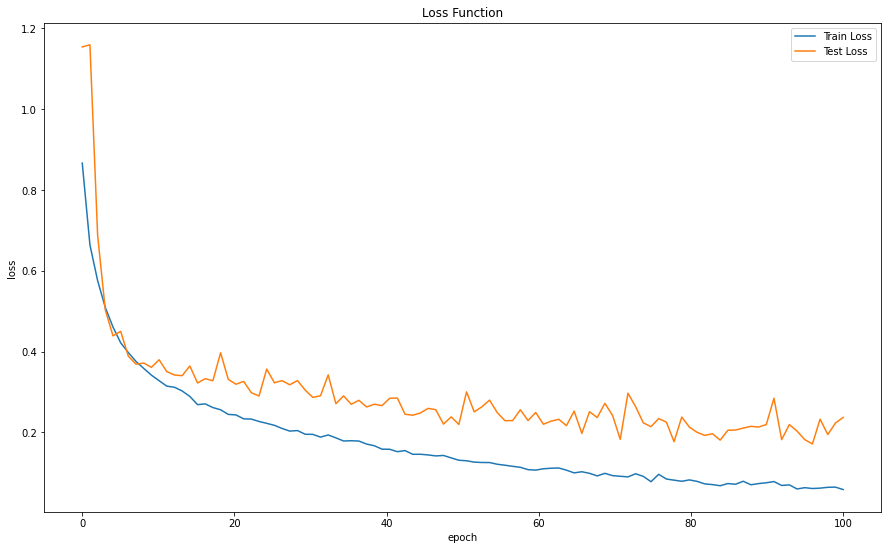

In [33]:
def Draw_Loss_Curve():
    plt.figure(figsize=(15, 9))
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss Function")
    x_loss = np.linspace(0, len(train_loss_list), len(train_loss_list))
    plt.plot(x_loss, train_loss_list, label=u'Train Loss', linewidth=1.5)
    plt.plot(x_loss, test_loss_list, label=u'Test Loss', linewidth=1.5)
    plt.legend()
    plt.show()
Draw_Loss_Curve()

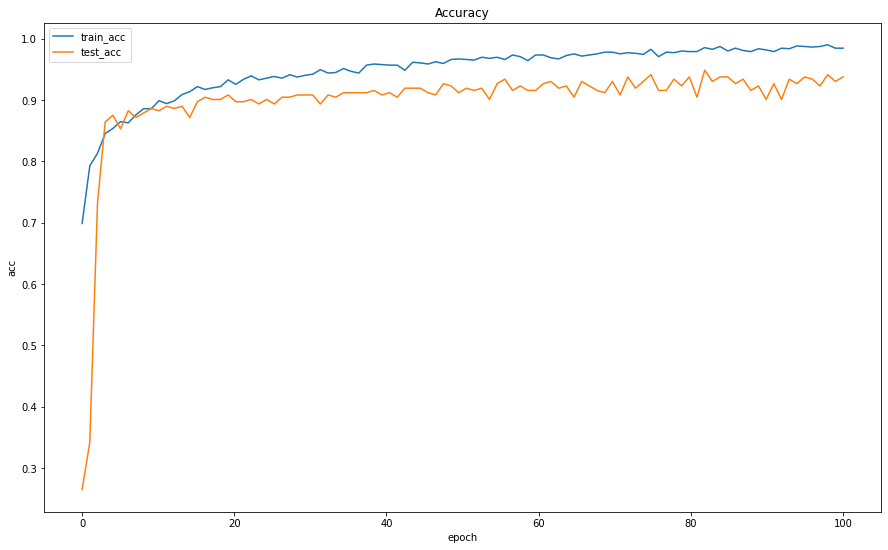

In [34]:
def Draw_Acc_Curve():
    plt.figure(figsize=(15, 9))
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.title("Accuracy")
    x_acc = np.linspace(0, len(train_acc_list), len(train_acc_list))
    plt.plot(x_acc, train_acc_list, label="train_acc", linewidth=1.5)
    plt.plot(x_acc, test_acc_list, label="test_acc", linewidth=1.5)
    plt.legend()
    plt.show()
Draw_Acc_Curve()

In [35]:
end = time.time()
print(end-begin)

452.4386842250824
